<a href="https://www.kaggle.com/code/pritam1202/movie-recommender-engine?scriptVersionId=183734005" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install surprise

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [3]:
raw_data = pd.read_csv(r"/kaggle/input/netflix-movie-dataset/combined_data_1.txt",header = None, names=['CustId','Rating','Date'])
netflix = raw_data

In [4]:
netflix

,CustId,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26
...,...,...,...
24058258,2591364,2.0,2005-02-16
24058259,1791000,2.0,2005-02-10
24058260,512536,5.0,2005-07-27
24058261,988963,3.0,2005-12-20


In [5]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   CustId  object 
 1   Rating  float64
 2   Date    object 
dtypes: float64(1), object(2)
memory usage: 550.7+ MB


In [6]:
netflix.isnull().sum()

CustId       0
Rating    4499
Date      4499
dtype: int64

In [7]:
netflix.shape

(24058263, 3)

In [8]:
netflix.head()

,CustId,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [9]:
netflix.tail()

,CustId,Rating,Date
24058258,2591364,2.0,2005-02-16
24058259,1791000,2.0,2005-02-10
24058260,512536,5.0,2005-07-27
24058261,988963,3.0,2005-12-20
24058262,1704416,3.0,2004-06-02


In [10]:
netflix[netflix['Rating'].isnull()]

,CustId,Rating,Date
0,1:,NaN,NaN
548,2:,NaN,NaN
694,3:,NaN,NaN
2707,4:,NaN,NaN
2850,5:,NaN,NaN
...,...,...,...
24046714,4495:,NaN,NaN
24047329,4496:,NaN,NaN
24056849,4497:,NaN,NaN
24057564,4498:,NaN,NaN


In [11]:
netflix['CustId'].nunique()

475257

In [12]:
netflix.isnull().sum()

CustId       0
Rating    4499
Date      4499
dtype: int64

# Creating the dataset 

In [13]:
Null_val = pd.DataFrame(netflix['Rating'].isnull())
Null_val

,Rating
0,True
1,False
2,False
3,False
4,False
...,...
24058258,False
24058259,False
24058260,False
24058261,False


### Extracting the null values in ratings as they are placeholders for the required movie ids

In [14]:
Null_val = Null_val[Null_val['Rating'] == True].reset_index()
Null_val

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


In [15]:
#there is a total of 4499 movie ids
len(Null_val)

4499

### Creating an array of movie ids to merge with the final dataset and assigning values in ascending order starting from 1

In [16]:
movie_id = []
movie = 1
for i in range(len(Null_val)-1):
    temp = np.full(((Null_val['index'][i+1]-Null_val['index'][i]-1),1),movie) #assigning values of movies with shape same as the differnce between each True values 
    movie_id = np.append(movie_id,temp)
    movie+=1

movie

4499

In [17]:
# Values filled till movie id 4498
len(set(movie_id))

4498

In [18]:
len(movie_id)

24053336

In [19]:
#adding the last movie id 4499 to movie_id
last = np.full(((netflix.index[-1]-Null_val['index'][len(Null_val)-1]),1),movie)
movie_id = np.append(movie_id,last)
len(set(movie_id))

4499

In [20]:
len(movie_id)

24053764

In [21]:
#removing the null values and the Date column
netflix = netflix.dropna().drop('Date',axis=1)
netflix.shape

(24053764, 2)

In [22]:
netflix

,CustId,Rating
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
5,823519,3.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


### Adding the movie ids to the netflix dataset 

In [23]:
netflix['MovieId'] = movie_id.astype(int)
netflix['CustId'] = netflix['CustId'].astype(int)
netflix

,CustId,Rating,MovieId
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


In [24]:
#importing the movie names
movie_name = pd.read_csv(r'/kaggle/input/netflix-movie-dataset/movie_titles.csv',header=None,names=['MovieId',"Release Year",'Movie_name'],usecols=[0,1,2])
movie_name.head()

,MovieId,Release Year,Movie_name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [25]:
#setting movie_id to index for filtering the movie names from 1 to 4499
movie_name.set_index('MovieId',inplace=True)
movie_name

,Release Year,Movie_name
MovieId,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17767,2004.0,Fidel Castro: American Experience
17768,2000.0,Epoch


In [26]:
movie_name.duplicated().sum()

16

In [27]:
movie_name[movie_name.duplicated()]

,Release Year,Movie_name
MovieId,,
4005,1993.0,Dr. Quinn
5223,1999.0,Girl
5712,1999.0,The Hunchback of Notre Dame
6063,1962.0,The Lucy Show
7351,2002.0,Pinocchio
9629,2002.0,Stranded
9827,2004.0,Frankenstein
10789,2000.0,Second Skin
11089,2001.0,Monsters


In [28]:
#extracting the required movies
movie_name = movie_name[0:4499]
movie_name

,Release Year,Movie_name
MovieId,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
4495,2002.0,Clifford: Happy Birthday Clifford / Puppy Love
4496,1993.0,Farewell My Concubine
4497,1990.0,Texasville


In [29]:
movie_name.duplicated().sum()

1

In [30]:
movie_name['Movie_name'].duplicated().sum()

28

In [31]:
movie_name.reset_index(inplace = True)
movie_name

,MovieId,Release Year,Movie_name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
4494,4495,2002.0,Clifford: Happy Birthday Clifford / Puppy Love
4495,4496,1993.0,Farewell My Concubine
4496,4497,1990.0,Texasville
4497,4498,2000.0,Gonin


### Merging the names to netflix dataset for ***Final dataset***

In [32]:
netflix = pd.merge(netflix,movie_name,on='MovieId',how='left')
netflix

,CustId,Rating,MovieId,Release Year,Movie_name
0,1488844,3.0,1,2003.0,Dinosaur Planet
1,822109,5.0,1,2003.0,Dinosaur Planet
2,885013,4.0,1,2003.0,Dinosaur Planet
3,30878,4.0,1,2003.0,Dinosaur Planet
4,823519,3.0,1,2003.0,Dinosaur Planet
...,...,...,...,...,...
24053759,2591364,2.0,4499,2002.0,In My Skin
24053760,1791000,2.0,4499,2002.0,In My Skin
24053761,512536,5.0,4499,2002.0,In My Skin
24053762,988963,3.0,4499,2002.0,In My Skin


# Analysis

In [33]:
netflix['CustId'].nunique()

470758

In [34]:
netflix['Rating'].value_counts()

Rating
4.0    8085741
3.0    6904181
5.0    5506583
2.0    2439073
1.0    1118186
Name: count, dtype: int64

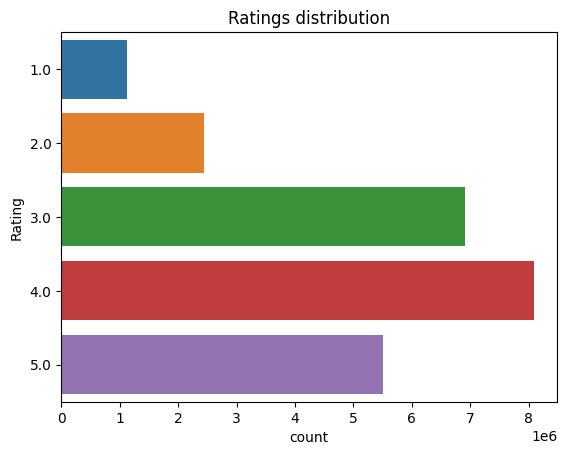

In [35]:
sns.countplot(data = netflix, y = 'Rating')
plt.title("Ratings distribution")
plt.show()

In [36]:
netflix['Release Year'].isnull().sum()

189

In [37]:
netflix['Release Year'].nunique()

89

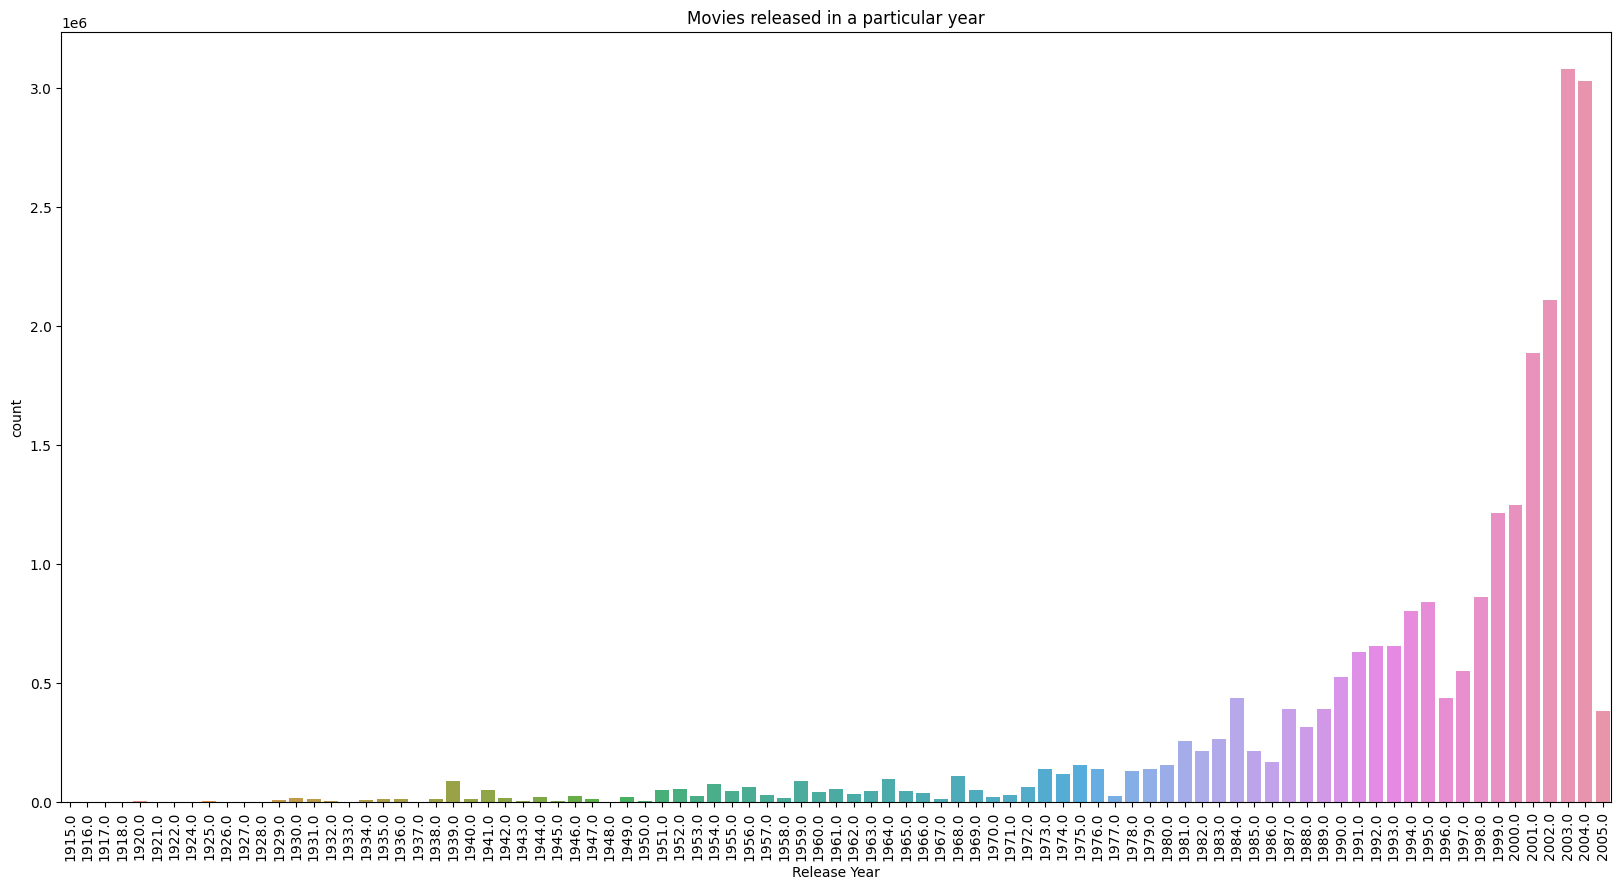

In [38]:
plt.figure(figsize=(20,10))
sns.countplot(data = netflix, x = "Release Year")
plt.title("Movies released in a particular year")
plt.xticks(rotation = 90)
plt.show()

In [39]:
netflix['Movie_name'].nunique()

4471

In [40]:
# Count of ratings for each movie
netflix.groupby('Movie_name')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
Movie_name,
Pirates of the Caribbean: The Curse of the Black Pearl,193941
What Women Want,162597
Bruce Almighty,160454
The Italian Job,156183
American Beauty,154832
...,...
Ghost Hunters: Season 1,44
Haven,43
Expo: Magic of the White City,42


In [42]:
# Count of 5 star ratings for each movie
netflix[netflix['Rating']==5].groupby('Movie_name')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
Movie_name,
Lord of the Rings: The Fellowship of the Ring,94655
Pirates of the Caribbean: The Curse of the Black Pearl,82549
Finding Nemo (Widescreen),79447
The Sixth Sense,74790
Braveheart,71154
...,...
Horror Vision,1
The Blackout,1
Postmortem,1


In [43]:
# Movies with no 5 start rating
print("Number of movies with no 5 star rating --> ", netflix['Movie_name'][~netflix['Movie_name'].isin(netflix[netflix['Rating']==5]['Movie_name'])].nunique())
pd.DataFrame(netflix['Movie_name'][~netflix['Movie_name'].isin(netflix[netflix['Rating']==5]['Movie_name'])].unique(), columns = ['Name'])

Number of movies with no 5 star rating -->  3


,Name
0,Option Zero
1,Avia Vampire Hunter
2,Bram Stoker's: To Die For


In [44]:
# Count of 1 star rating for each movie
netflix[netflix['Rating']==1].groupby('Movie_name')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
Movie_name,
Napoleon Dynamite,13365
The Wedding Planner,12194
What Women Want,8855
Patch Adams,8375
About Schmidt,8334
...,...
Ghost Hunters: Season 1,2
Casino: 10th Anniversary Edition: Bonus Material,2
Girls Bravo,2


In [45]:
# Movies with no 1 start rating
print("Number of movies with no 1 star rating --> ", netflix['Movie_name'][~netflix['Movie_name'].isin(netflix[netflix['Rating']==1]['Movie_name'])].nunique())
pd.DataFrame(netflix['Movie_name'][~netflix['Movie_name'].isin(netflix[netflix['Rating']==1]['Movie_name'])].unique(), columns = ['Name'])

Number of movies with no 1 star rating -->  1


,Name
0,Lord of the Rings: The Return of the King: Ext...


In [46]:
# Average rating of each movie
netflix.groupby('Movie_name')['Rating'].agg(['mean']).sort_values(by=['mean'],ascending=False)

,mean
Movie_name,
Lost: Season 1,4.670989
Ghost in the Shell: Stand Alone Complex: 2nd Gig,4.586364
The Simpsons: Season 6,4.581296
Inu-Yasha,4.554434
Lord of the Rings: The Return of the King: Extended Edition: Bonus Material,4.552000
...,...
The Horror Within,1.496241
Half-Caste,1.487395
Dark Harvest 2: The Maize,1.452381


In [47]:
#Rating count for each customer
netflix['CustId'].value_counts()

CustId
305344     4467
387418     4422
2439493    4195
1664010    4019
2118461    3769
           ... 
1300341       1
2550360       1
11848         1
930788        1
594210        1
Name: count, Length: 470758, dtype: int64

In [48]:
#5 star rating count for each customer
netflix[netflix['Rating']==5]['CustId'].value_counts()

CustId
1664010    2060
794999     1291
2118461    1243
447759      976
716173      861
           ... 
2187569       1
1535655       1
1519197       1
1853858       1
73944         1
Name: count, Length: 410201, dtype: int64

In [49]:
#1 star rating count for each customer
netflix[netflix['Rating']==1]['CustId'].value_counts()

CustId
2439493    3851
305344     2416
1639792    2139
1461435    2068
387418     1955
           ... 
2370250       1
1168949       1
35561         1
162240        1
2541000       1
Name: count, Length: 241379, dtype: int64

## Data cleaning 
### (for limited resources)

In [50]:
#Movies with ratings count less than 70 percentile
movie_cut_off = round(netflix.groupby('MovieId')['Rating'].agg(['count'])['count'].quantile(0.7),0)
drop_movie_list = netflix.groupby('MovieId')['Rating'].agg(['count'])[netflix.groupby('MovieId')['Rating'].agg(['count'])['count'] < movie_cut_off].index
drop_movie_list

Index([   1,    2,    4,    5,    6,    7,    9,   10,   11,   12,
       ...
       4484, 4486, 4487, 4489, 4491, 4494, 4495, 4497, 4498, 4499],
      dtype='int64', name='MovieId', length=3149)

In [51]:
#Customer that have given rating less than 70 percentile
cust_cut_off = round(netflix.groupby('CustId')['Rating'].agg(['count'])['count'].quantile(0.7),0)
drop_cust_list = netflix.groupby('CustId')['Rating'].agg(['count'])[netflix.groupby('CustId')['Rating'].agg(['count'])['count'] < cust_cut_off].index
drop_cust_list

Index([      8,      10,      25,      33,      42,      59,      83,      87,
            94,     116,
       ...
       2649343, 2649351, 2649375, 2649376, 2649379, 2649384, 2649401, 2649404,
       2649409, 2649421],
      dtype='int64', name='CustId', length=327300)

In [52]:
netflix.shape

(24053764, 5)

In [53]:
#Dropping customer and movie that are in drop list
netflix_data = netflix[(~netflix['MovieId'].isin(drop_movie_list))&(~netflix['CustId'].isin(drop_cust_list))]
netflix_data.shape

(17337458, 5)

# Model fitting and rating prediction

In [ ]:
from surprise import Reader, SVD, Dataset
from surprise.model_selection import cross_validate

In [ ]:
netflix_data.head()

In [ ]:
#arranging data to feed the SVD model
reader = Reader()
model_data = Dataset.load_from_df(netflix_data[['CustId','MovieId','Rating']][0:7500000],reader)
model_data

In [ ]:
#model fitting and cross validation
model = SVD()
cross_validate(model,model_data,measures=['RMSE','MAE'],cv=4)

In [ ]:
#predictng ratings for user 1664010
user_1664010 = movie_name[~movie_name['MovieId'].isin(drop_movie_list)]
user_1664010['Estimated rating'] = user_1664010['MovieId'].apply(lambda x: model.predict(1664010,x).est)
user_1664010

In [ ]:
#RMSE of prediction
ratings_1664010 = netflix_data[['MovieId','Rating']][netflix_data['CustId']==1664010].sort_values(by='MovieId',ascending=False)
pred_1664010 = user_1664010[['MovieId','Estimated rating']][user_1664010['MovieId'].isin(ratings_1664010['MovieId'])].sort_values(by='MovieId',ascending=False)
RMSE = np.sqrt(metrics.mean_squared_error(ratings_1664010['Rating'],pred_1664010['Estimated rating']))
print('The RMSE of model for user 1664010 is --> ', RMSE)

In [ ]:
#predictng ratings for user 2439493
user_2439493 = movie_name[~movie_name['MovieId'].isin(drop_movie_list)]
user_2439493['Estimated rating'] = user_2439493['MovieId'].apply(lambda x: model.predict(2439493,x).est)
user_2439493

In [ ]:
#RMSE of prediction
ratings_2439493 = netflix_data[['MovieId','Rating']][netflix_data['CustId']==2439493].sort_values(by='MovieId',ascending=False)
pred_2439493 = user_2439493[['MovieId','Estimated rating']][user_2439493['MovieId'].isin(ratings_2439493['MovieId'])].sort_values(by='MovieId',ascending=False)
MSE = metrics.mean_squared_error(ratings_2439493['Rating'],pred_2439493['Estimated rating'])
RMSE = np.sqrt(metrics.mean_squared_error(ratings_2439493['Rating'],pred_2439493['Estimated rating']))
print('The RMSE of model for user 2439493 is --> ', RMSE)

In [ ]:
#importing Genre dataset
genre_data = pd.read_csv("/kaggle/input/netflix-movie-dataset/movies.csv")

In [ ]:
genre_data.sort_values(by='movieId',ascending = True, inplace = True)
genre_data.rename(columns={'movieId':'MovieId'}, inplace=True)
genre_data

In [ ]:
netflix.shape

In [ ]:
movie_genre = pd.merge(netflix,genre_data[genre_data['MovieId'].isin(movie_name['MovieId'])], how='left', on='MovieId')
movie_genre

In [ ]:
#Highest rated genre
drop_genre_list = movie_genre.groupby('genres')['Rating'].agg(['count'])[movie_genre.groupby('genres')['Rating'].agg(['count'])['count']<round(movie_genre.groupby('genres')['Rating'].agg(['count'])['count'].quantile(0.95),0)].index
Highest_rated_genre = movie_genre[~movie_genre['genres'].isin(drop_genre_list)]
Highest_rated_genre.groupby('genres')['Rating'].agg(['count']).sort_values(by='count',ascending=False)

In [ ]:
# Highest 5 star rated genre
genre_rating5 = movie_genre[movie_genre['Rating']==5]
drop_genre_list5 = genre_rating5.groupby('genres')['Rating'].agg(['count'])[genre_rating5.groupby('genres')['Rating'].agg(['count'])['count']<round(genre_rating5.groupby('genres')['Rating'].agg(['count'])['count'].quantile(0.95),0)].index
Highest_rated5_genre = genre_rating5[~movie_genre['genres'].isin(drop_genre_list5)]
Highest_rated5_genre.groupby('genres')['Rating'].agg(['count']).sort_values(by='count',ascending=False)

In [ ]:
#Data cleaning
movie_genre_filtered = movie_genre[(~movie_genre['MovieId'].isin(drop_movie_list)) & (~movie_genre['CustId'].isin(drop_cust_list))]
movie_genre_filtered.shape

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()

In [ ]:
# movie_genre_filtered['genres'] = le.fit_transform(movie_genre_filtered['genres'])

In [ ]:
# movie_genre_filtered

In [ ]:
#arranging the data to fit the SVD model
# model_genre_data = Dataset.load_from_df(movie_genre_filtered[['CustId','genres','Rating']][0:7500000],reader)

In [ ]:
#model fitting and cross validation
# model_genre = SVD()
# cross_validate(model_genre,model_genre_data,measures=['RMSE','MAE'],cv=4)